In [1]:
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read and verify the dataset
df = pd.read_csv("sydney_traffic_incidents_clean.csv")
df.head()

,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,...,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD,duration_class
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,...,1,0,0,0,0,2,8,19,15.781064,1
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,...,0,0,0,0,1,1,8,0,8.323913,0
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,...,1,0,0,0,0,1,8,1,34.354983,0
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,...,1,1,0,0,0,1,8,1,22.500677,1
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,...,0,0,0,0,0,3,8,1,22.753003,1


In [3]:
y = df["duration_class"]

# if duration is included, we get almost perfect results, which makes perfect sense since it determines the class, so remove duration since the target is duration_class
X = df.drop(columns=["duration_class", "duration"])

In [4]:
# SVM handles numeric types just fine, but they must be scaled so select them out
numeric_cols = X.select_dtypes(include=["float64", "float32"]).columns.tolist()

# int columns are likely categories. these should be one-hot encoded
int_cols = X.select_dtypes(include=["int64", "int32"]).columns.tolist()

# however, I ran into a big issue with some of them, which is that they have waaay too many categories
# to deal with this, I will have to remove the high cardinality columns before one-hot encoding because they choke the model
cardinality = X[int_cols].nunique().sort_values()

low_cardinality = [c for c in int_cols if X[c].nunique() <= 50]
high_cardinality = [c for c in int_cols if X[c].nunique() > 50]

print("Low-cardinality categorical:", low_cardinality[:10])
print("High-cardinality to drop:", high_cardinality[:10])


Low-cardinality categorical: ['Main_Category', 'Day', 'Primary_Vehicle', 'Secondary_Vehicle', 'Is_Major_Incident', 'Advice_A', 'Closure_Type', 'Direction', 'Affected_Lanes', 'Actual_Number_of_Lanes']
High-cardinality to drop: ['Advice_B', 'Main_Street', 'Suburb', 'SA2_CODE21', '12_NoN', '13_NDEs', '15_NNC3L', '16_NNC4L', '18_NE', '21 NBS']


In [5]:
# drop the high cardinality columns
X_filtered = X.drop(columns=high_cardinality)

#one-hot encode and scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), low_cardinality)
    ]
)

In [6]:
# finally, split and train the model
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, shuffle=True
)

svm_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", SVC(kernel="rbf", class_weight="balanced"))
])
start_time = time.time()
svm_clf.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 900.41 seconds


Accuracy: 0.6689258698940999

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.69      0.68      8520
           1       0.66      0.65      0.65      8005

    accuracy                           0.67     16525
   macro avg       0.67      0.67      0.67     16525
weighted avg       0.67      0.67      0.67     16525



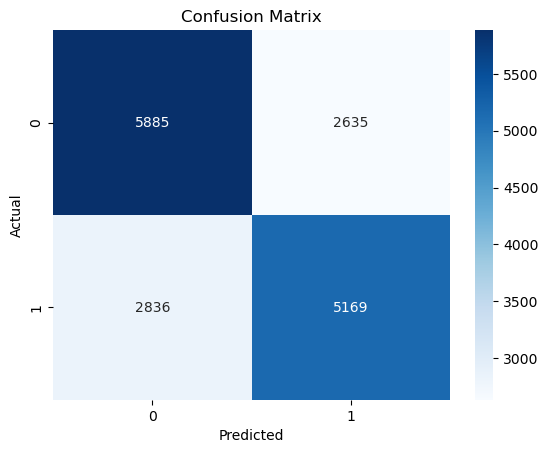

In [7]:
# test our results
y_pred = svm_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [8]:
# now, let's perform a similar process, but I'll use the Linear SVM version. This should perform faster but will likely get worse results
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), low_cardinality)
    ]
)

linear_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LinearSVC(class_weight="balanced", max_iter=5000))
])

start_time = time.time()
linear_svm.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 9.76 seconds


Accuracy: 0.6655975794251134

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      8520
           1       0.66      0.65      0.65      8005

    accuracy                           0.67     16525
   macro avg       0.67      0.67      0.67     16525
weighted avg       0.67      0.67      0.67     16525



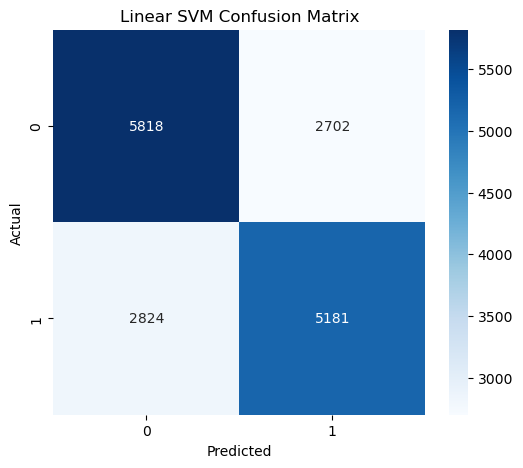

In [9]:
# predict and get metrics
y_pred = linear_svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# now let's look at feature importance. I will use the permutation_importance library on both SVM and linear SVM. First SVM:
result_svm = permutation_importance(
    svm_clf,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)

svm_importances = pd.Series(
    result_svm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

print(svm_importances.head(20))

KeyboardInterrupt: 

In [11]:
# now Linear SVM:
result_linear_svm = permutation_importance(
    linear_svm,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
)

svm_importances = pd.Series(
    result_linear_svm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

print(svm_importances.head(20))

Primary_Vehicle            0.066638
Secondary_Vehicle          0.057682
distance_to_CBD            0.015806
Num_Vehicles_Involved      0.013047
Transport for NSW          0.011244
SA3_NAME21                 0.011147
Traffic_Volume             0.010675
Hour                       0.010045
Latitude                   0.010033
Advice_A                   0.009489
Actual_Number_of_Lanes     0.007455
RMS                        0.006209
17_AND                     0.005241
Motorway Crew              0.005047
36_PD2MV                   0.004381
Heavy vehicle tow truck    0.004091
Incident_Type              0.003897
42_NPTtWbyTx               0.003328
Is_Major_Incident          0.003256
6_TrRL                     0.003062
dtype: float64


After excessive runtime of approximately 2 hours for the permutation_importance on SVM, I investigated the causes and found that this method of feature analysis is generally not recommended, and especially not recommended for a dataset like the Sydney incident dataset. I interupted that process and proceeded with the same analysis on the Linear SVM, which performed almost as well as SVM but in a tiny fraction of the time. 